# Labeled Faces In The Wild Deep Learning Classification


## Desription

The LFW (Labeled Faces In The Wild) dataset is composed of 5479 clases (different persons) for more than 13000 images.

## Initialization

In [12]:
# IMSIZE = [250, 250, 3]

## Load dataset

In [13]:
from sklearn.datasets import fetch_lfw_people

# Load dataset in color mode with centered on the faces
lfw_people = fetch_lfw_people(min_faces_per_person=1, color=True, resize=1.0,
                              slice_=(slice(70, 195), slice(78, 172)), funneled=True)

X = lfw_people.data
y = lfw_people.target

target_names = lfw_people.target_names
n_classes = target_names.shape[0]
n_samples, h, w, l = lfw_people.images.shape

# Reshape images 1D array to images matrix
X = X.reshape(-1, h, w, l).astype('uint8')

## Show images infos

In [14]:
print(target_names)
print(f"Image dimensions: {w}x{h}x{l}")
print(f"Number of classes: {n_classes}")
print(f"Number of samples: {n_samples}")

['AJ Cook' 'AJ Lamas' 'Aaron Eckhart' ... 'Zumrati Juma' 'Zurab Tsereteli'
 'Zydrunas Ilgauskas']
Image dimensions: 94x125x3
Number of classes: 5749
Number of samples: 13233


## Show images

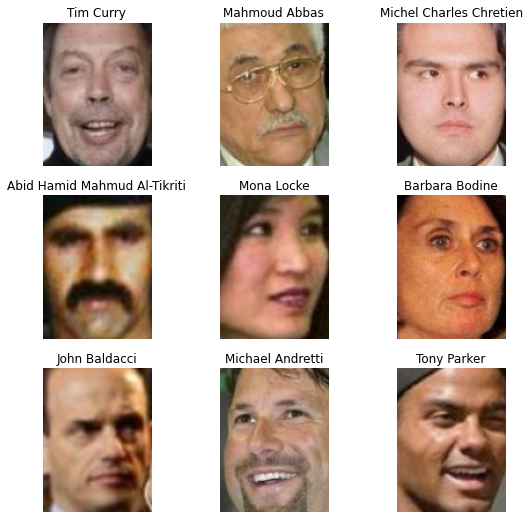

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X[i])
    plt.title(target_names[y[i]])
    plt.axis("off")
plt.show()

## Split dataset

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building model


In [17]:
from tensorflow import keras
from keras.optimizers import SGD
from keras import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.applications import ResNet50

batch_size = 8
epochs = 50
number_of_last_layers_trainable = 10
learning_rate = 0.001
nesterov = True
momentum = 0.9

preprocess_input = keras.applications.resnet.preprocess_input

model = ResNet50(
    input_shape=[h, w, 3],
    weights="imagenet",
    include_top=False,
    classes=n_classes,
)

for layer in model.layers[: number_of_last_layers_trainable]:
    layer.trainable = False

out = model.output

x = Flatten()(out)
x = Dense(n_classes, activation="softmax")(x)

model = Model(inputs=model.input, outputs=x)

opti = SGD(
    learning_rate=learning_rate,
    momentum=momentum,
    nesterov=nesterov,
)

# model.compile(loss="sparse_categorical_crossentropy", optimizer=opti, metrics=["accuracy"])

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opti, metrics=["accuracy"])
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 125, 94, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 131, 100, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 63, 47, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 63, 47, 64)   256         ['conv1_conv[0][0]']       

## Data augmentation

In [18]:
from keras_preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.05,
    shear_range=10,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.20,
    preprocessing_function=preprocess_input,
)

train_generator = image_gen.flow(
    x=X_train,
    y=y_train,
    shuffle=True,
    batch_size=batch_size,
)

test_generator = image_gen.flow(
    x=X_test,
    y=y_test,
    shuffle=True,
    batch_size=batch_size,
)

## Training

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", patience=2)
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=epochs,
                    callbacks=[early_stop])

Epoch 1/50
1324/1324 [==============================] - 421s 249ms/step - loss: 7.9005 - accuracy: 0.0753 - val_loss: 7.2345 - val_accuracy: 0.1175
Epoch 2/50
1324/1324 [==============================] - 141s 106ms/step - loss: 6.3834 - accuracy: 0.1717 - val_loss: 6.8340 - val_accuracy: 0.1776
Epoch 3/50
1267/1324 [===========================>..] - ETA: 5s - loss: 4.6967 - accuracy: 0.2839

## Save model

In [ ]:
model.save_weights("../weights/resnet50_lfw.h5")

## Prediction test

In [ ]:
image_index = 100
y_pred_mytest = model.predict(X[image_index:image_index + 9])

## Prediction display

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    text = f"Real: {target_names[y[image_index + i]]}\nPredicted: {target_names[np.argmax(y_pred_mytest[i])]}"
    plt.title(text)
    plt.imshow(X[image_index + i])
    plt.axis("off")
plt.show()
